<h1> Entrega  Proyecto Final </h1>



Integrantes del equipo:


*   Miguel Ángel Verdi
*   Jorge Esaú Reséndiz
*   Miguel Villalobos
*   José Pablo González
*   Gerardo Pájaro

In [94]:
import pandas as pd
import numpy as np

df_train = pd.read_csv('df_train.csv')


* Datos de validación

In [108]:
headers = [
    'unit_number', 'time', 'opSet1', 'opSet2', 'opSet3',
    'senMes1', 'senMes2', 'senMes3', 'senMes4', 'senMes5',
    'senMes6', 'senMes7', 'senMes8', 'senMes9', 'senMes10',
    'senMes11', 'senMes12', 'senMes13', 'senMes14', 'senMes15',
    'senMes16', 'senMes17', 'senMes18', 'senMes19', 'senMes20',
    'senMes21'
]

df_validation_FD001 = pd.read_csv('test_FD001.txt', sep='\s+', header=None, names=headers)
y_validation_FD001 = pd.read_csv('RUL_FD001.txt', sep='\s+', header=None, names=['RUL'])

Para la validación se toma solamente el ultimo dato del data set

In [183]:


rows = []

for unit_number in df_validation_FD001['unit_number'].unique():
    df_max_cycles = df_validation_FD001[df_validation_FD001['unit_number'] == unit_number]
    mx_time = df_max_cycles['time'].max()
    
    new_row = df_max_cycles[df_max_cycles['time'] == mx_time].values
    rows.append(new_row[0])
    

df_validation_FD001_max = pd.DataFrame(rows, columns=headers)


* Funcion para agregar el RUL a cada fila del data set, usando el tiempo maximo encontrado.
* train será el data set con el que se entranará y evaluará la red haciendo un split 30-70.

In [15]:
def add_RUL_column(df):
    train_grouped_by_unit = df.groupby(by='unit_number')
    max_time_cycles = train_grouped_by_unit['time'].max()
    merged = df.merge(max_time_cycles.to_frame(name='max_time_cycle'), left_on='unit_number',right_index=True)
    merged["RUL"] = merged["max_time_cycle"] - merged['time']
    merged = merged.drop("max_time_cycle", axis=1)
    return merged
train = add_RUL_column(df_train)

<h1> Analisis y selección de variables de entrada </h1>

* Se hace un plot entre los sensores y el RUL para visualizar su relación, esto en los data set FD001 y FD003

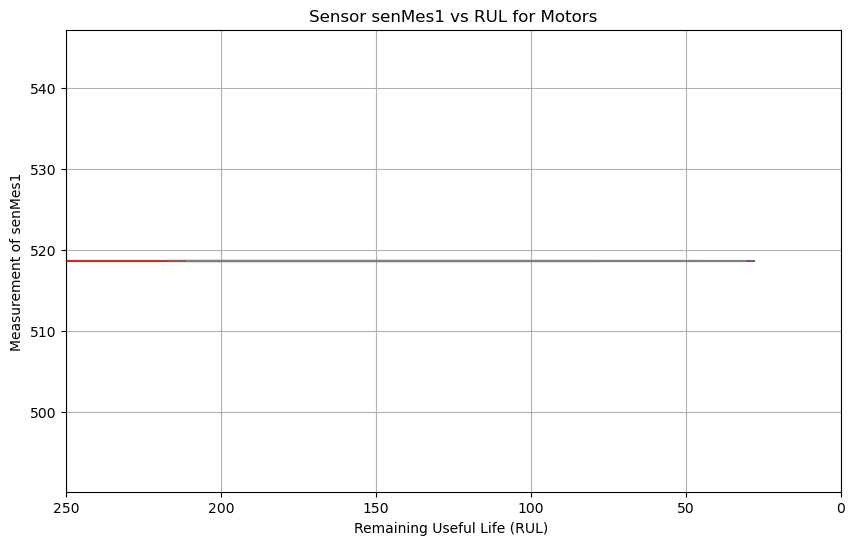

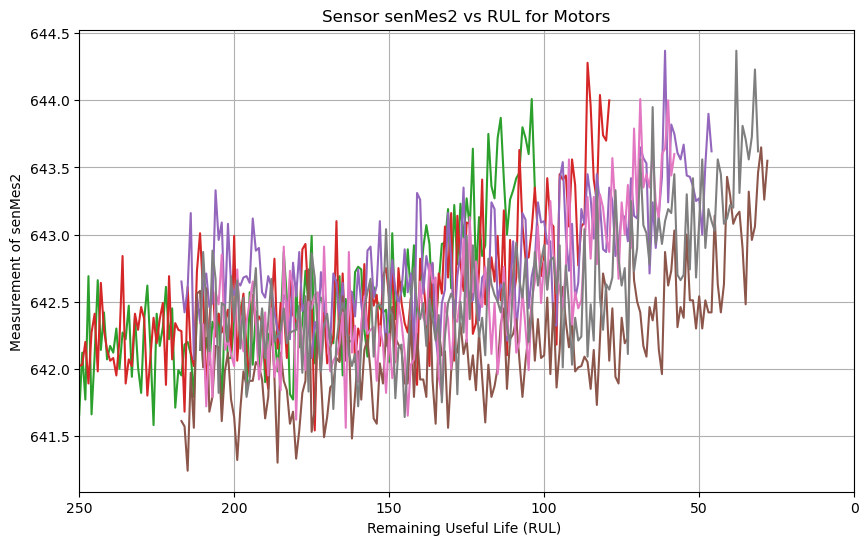

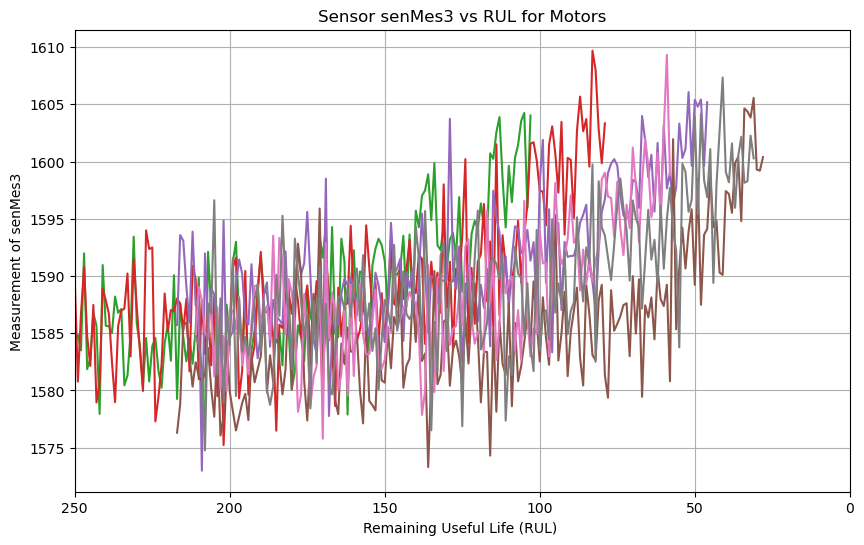

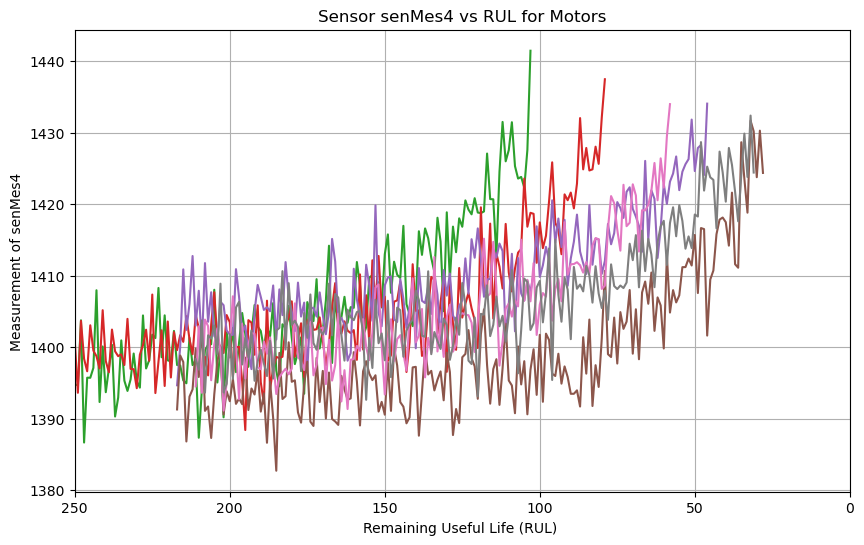

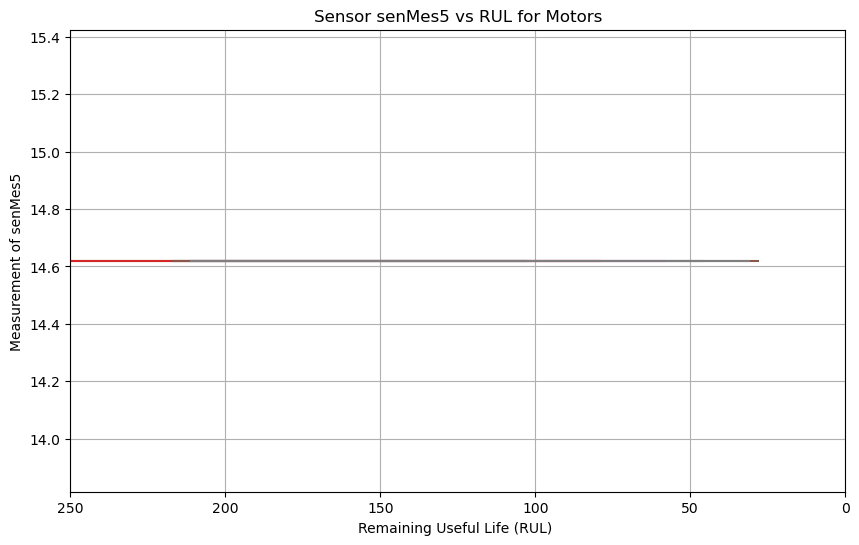

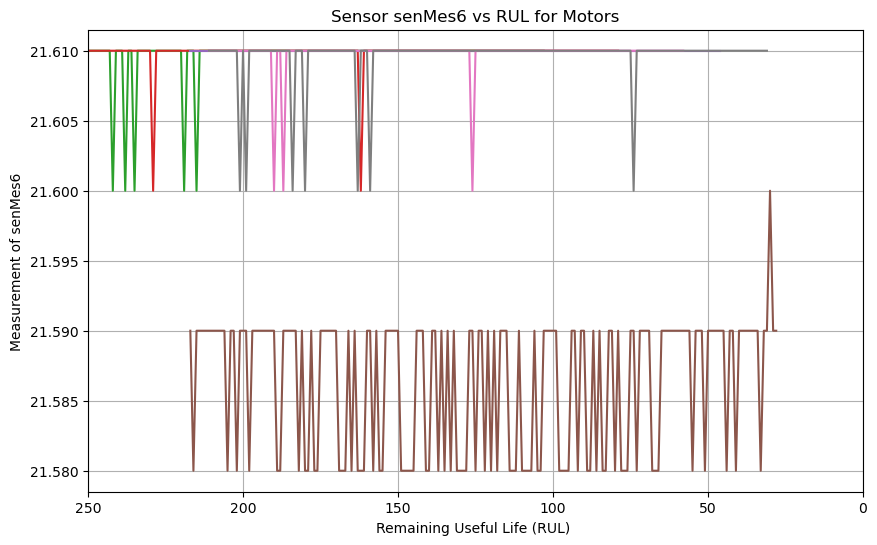

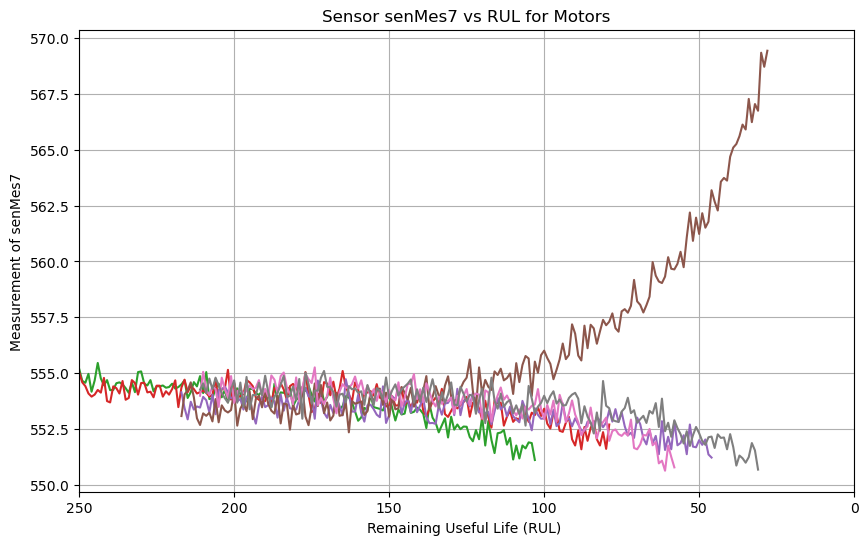

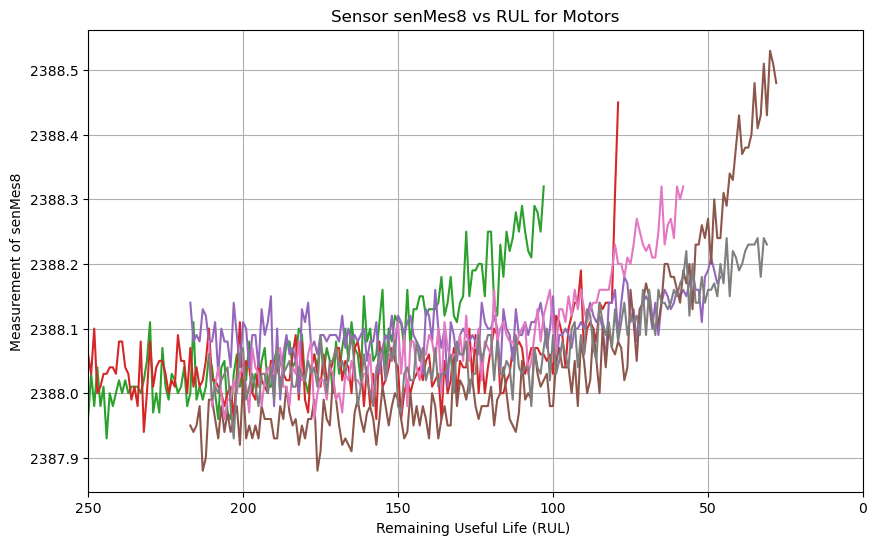

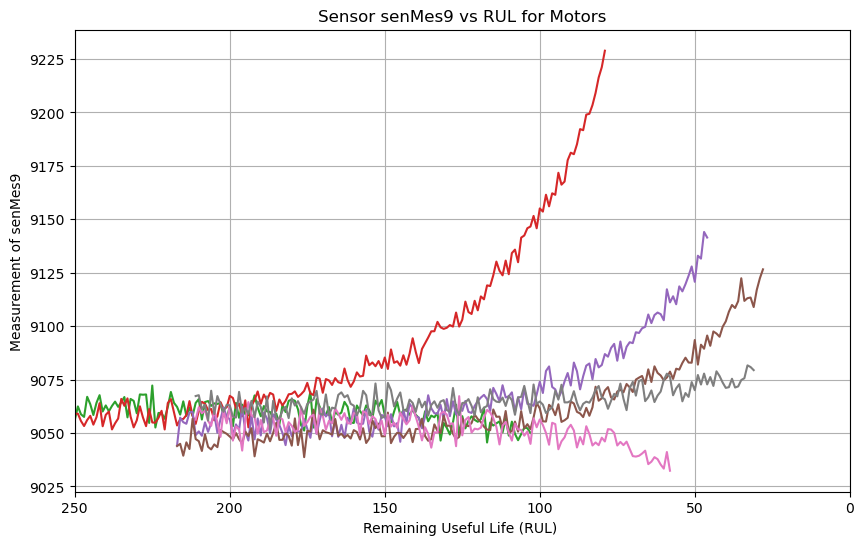

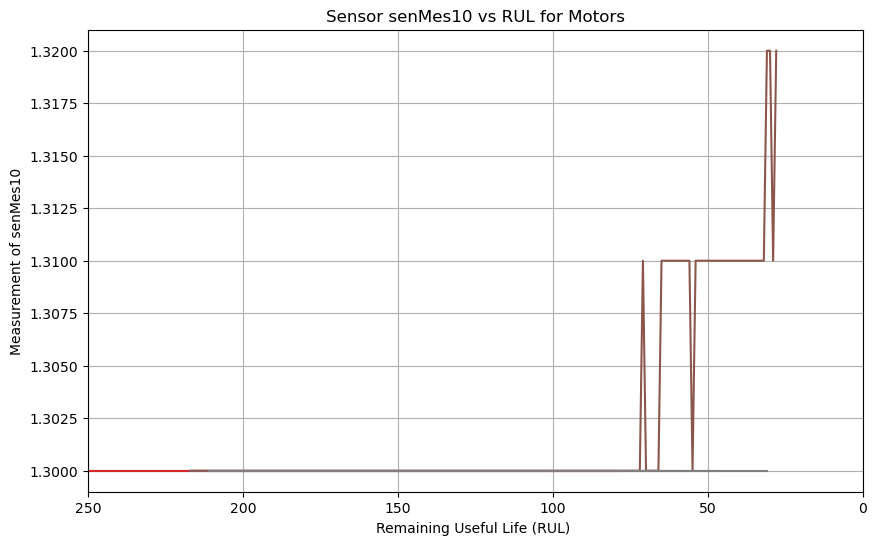

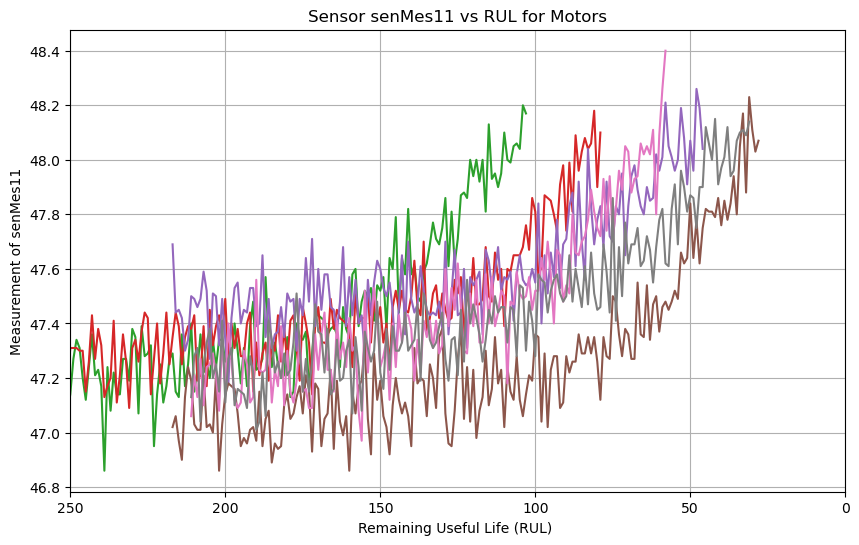

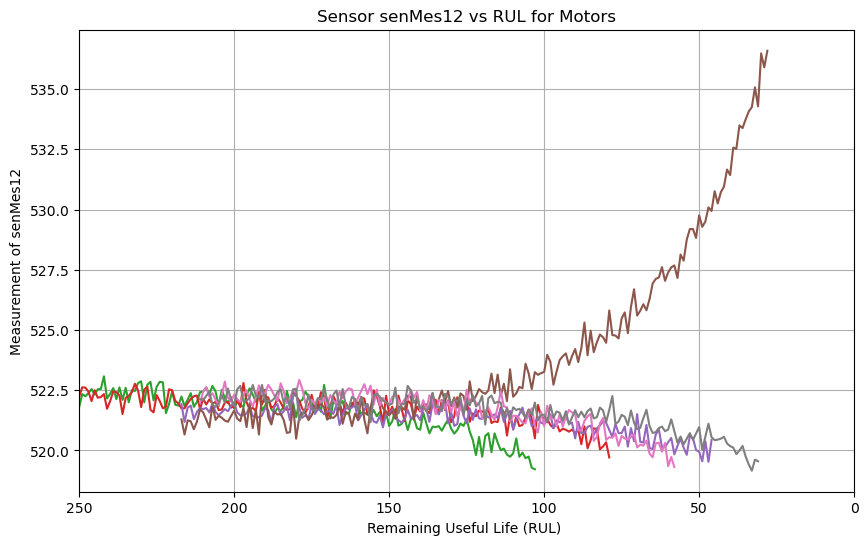

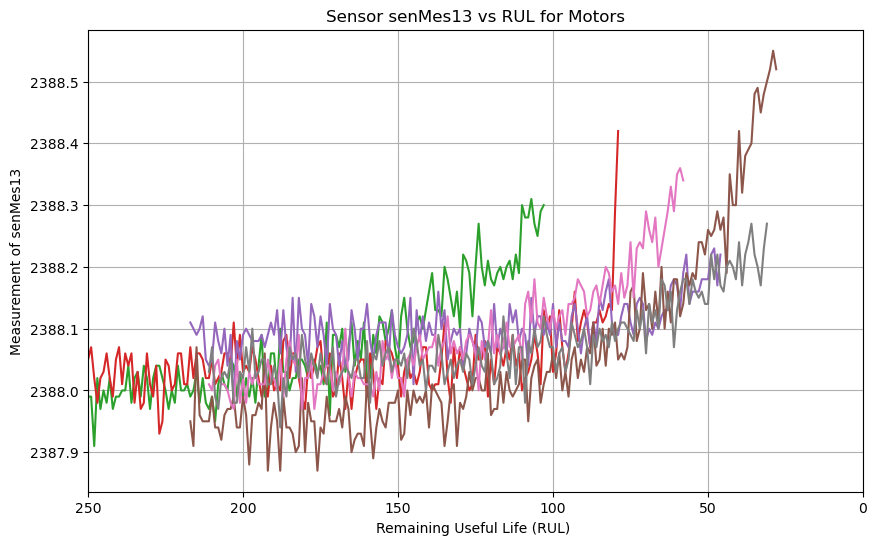

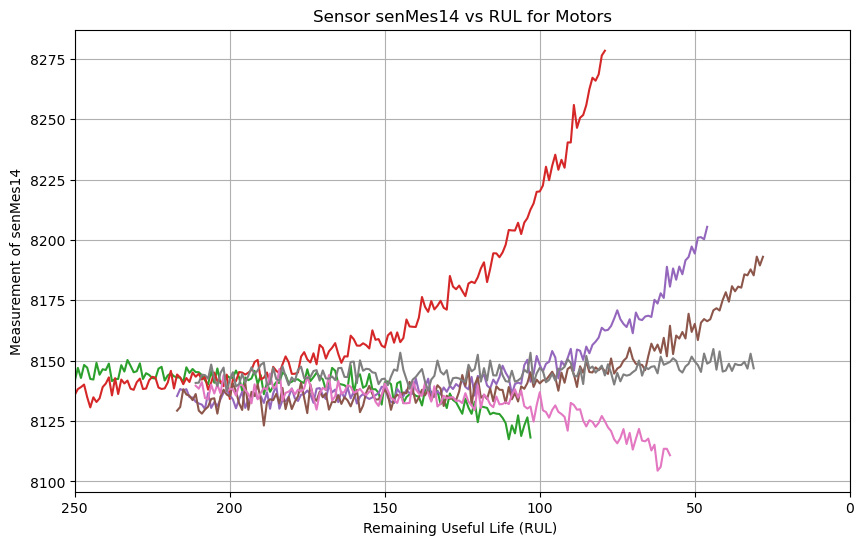

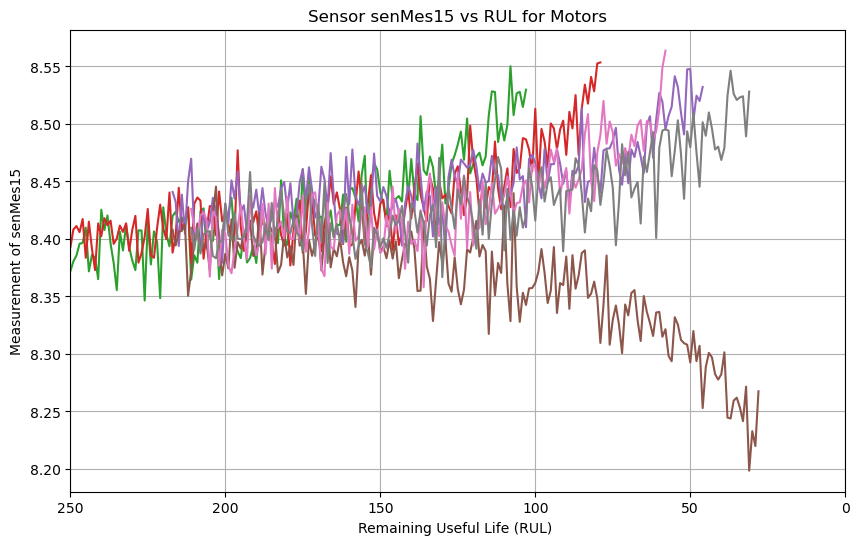

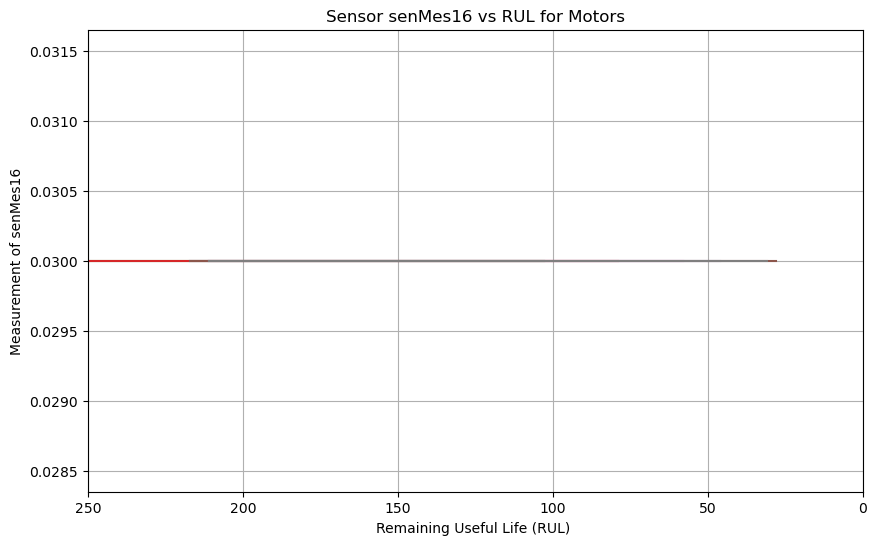

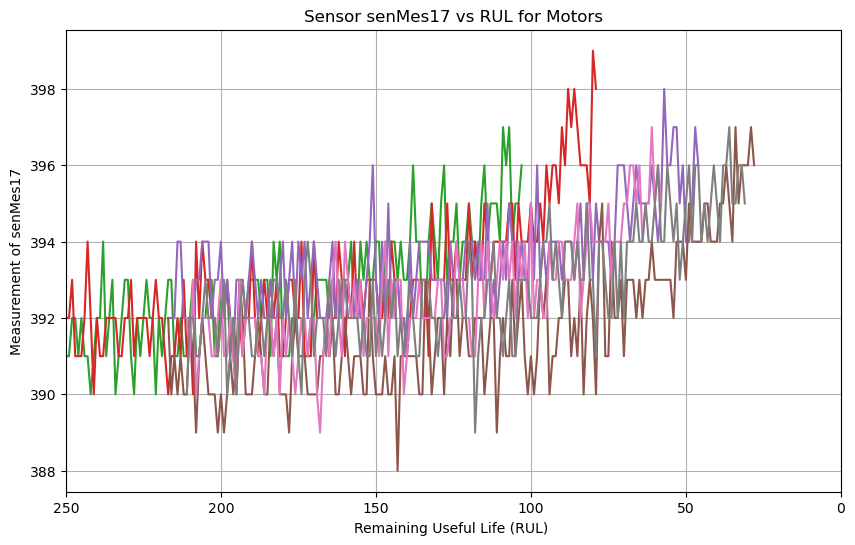

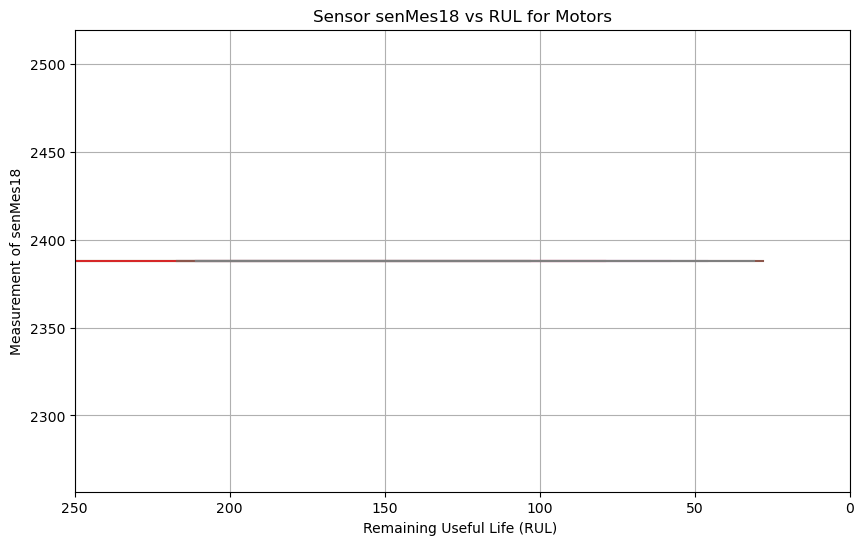

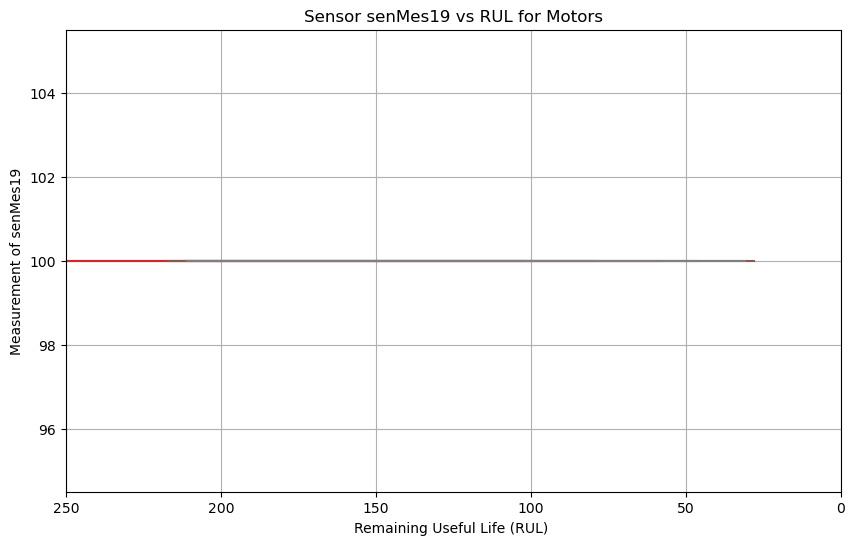

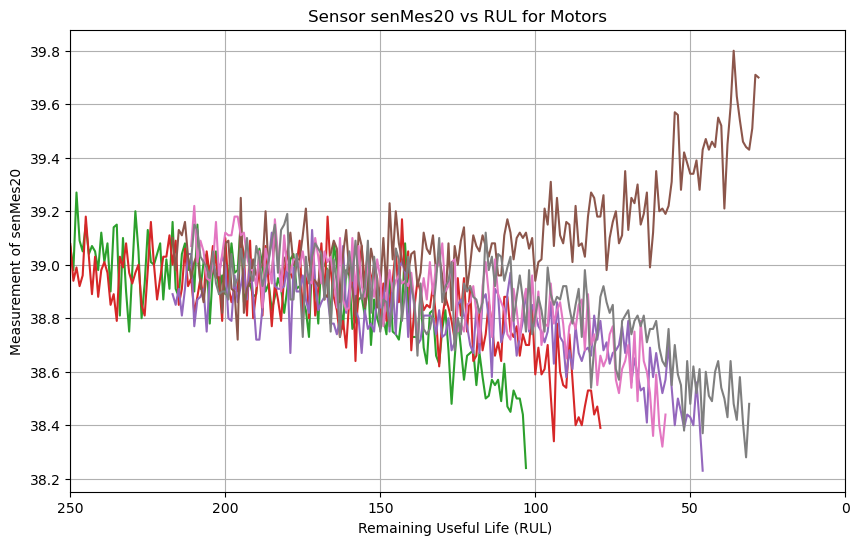

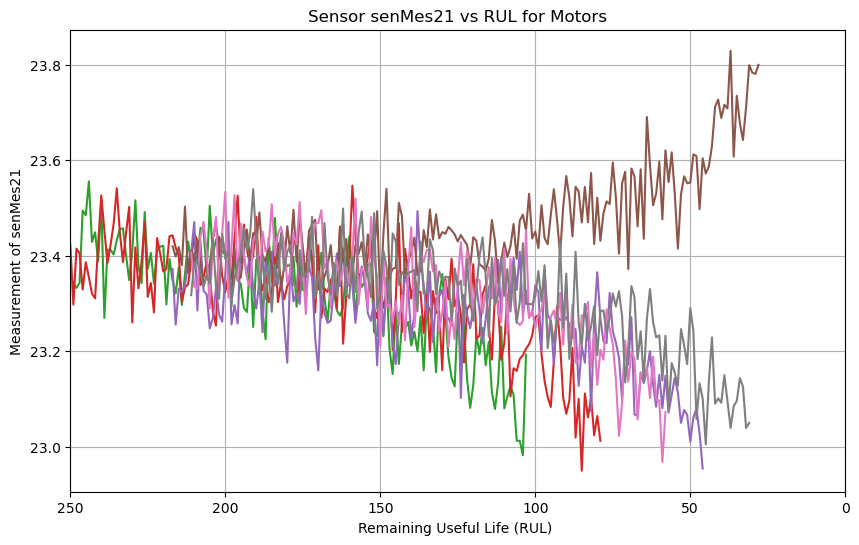

In [17]:
import matplotlib.pyplot as plt

plotHeaders = [
    'senMes1', 'senMes2', 'senMes3', 'senMes4', 'senMes5',
    'senMes6', 'senMes7', 'senMes8', 'senMes9', 'senMes10',
    'senMes11', 'senMes12', 'senMes13', 'senMes14', 'senMes15',
    'senMes16', 'senMes17', 'senMes18', 'senMes19', 'senMes20',
    'senMes21'
]


def plot_signal(df, sensor):
  
    plt.figure(figsize=(10, 6))
    sample = np.arange(0, 101, 30)
    
    for motor_number in sample:
        motor = df[(df['unit_number']== motor_number) & (df['dataSet']== 'FD001')]
        x = motor[sensor].values
        y = motor['RUL'].values
        text = "Data set FD001" 
        plt.plot(y,x, label = text)
    
        motor = df[(df['unit_number']==motor_number) & (df['dataSet']== 'FD003')]
        x = motor[sensor].values
        y = motor['RUL'].values
        text = "Data set FD003" 
        plt.plot(y,x, label = text)

          
    plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
    plt.ylabel(f'Measurement of {sensor}')
    plt.xlabel('Remaining Useful Life (RUL) ')
    plt.title(f'Sensor {sensor} vs RUL for Motors')
    plt.grid(True) 
    plt.show()



for i in range(0,21):
    plot_signal(train, plotHeaders[i])

* Para propositos de entrenamiento se ve que algunos sensores como el 1,5,6,10, etc no tienen un aporte al RUL y se descartan junto a las otras caracteristicas

In [22]:
from sklearn.model_selection import train_test_split

drop_labels = [
    'unit_number', 'time', 'opSet1', 'opSet2', 'opSet3',
    'senMes1', 'senMes5', 'senMes6', 'senMes10', 'senMes16',
    'senMes18','senMes19', 'FM', 'conditions',  'dataSet'
    ]

Train=train.drop(columns=drop_labels).copy()

* Split de datos en sets para entrenamiento  y para test.

In [27]:
X_train, X_test, y_train, y_test=train_test_split(Train,Train['RUL'], test_size=0.3, random_state=42)

X_test=X_test.drop(columns='RUL').copy()

X_train=X_train.drop(columns='RUL').copy()


* Escalado de datos usando MinMaxScaler

In [30]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

scaler = MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)


* Histogramas del comportamiento de los sensores

array([[<Axes: title={'center': 'senMes2'}>,
        <Axes: title={'center': 'senMes3'}>,
        <Axes: title={'center': 'senMes4'}>,
        <Axes: title={'center': 'senMes7'}>],
       [<Axes: title={'center': 'senMes8'}>,
        <Axes: title={'center': 'senMes9'}>,
        <Axes: title={'center': 'senMes11'}>,
        <Axes: title={'center': 'senMes12'}>],
       [<Axes: title={'center': 'senMes13'}>,
        <Axes: title={'center': 'senMes14'}>,
        <Axes: title={'center': 'senMes15'}>,
        <Axes: title={'center': 'senMes17'}>],
       [<Axes: title={'center': 'senMes20'}>,
        <Axes: title={'center': 'senMes21'}>, <Axes: >, <Axes: >]],
      dtype=object)

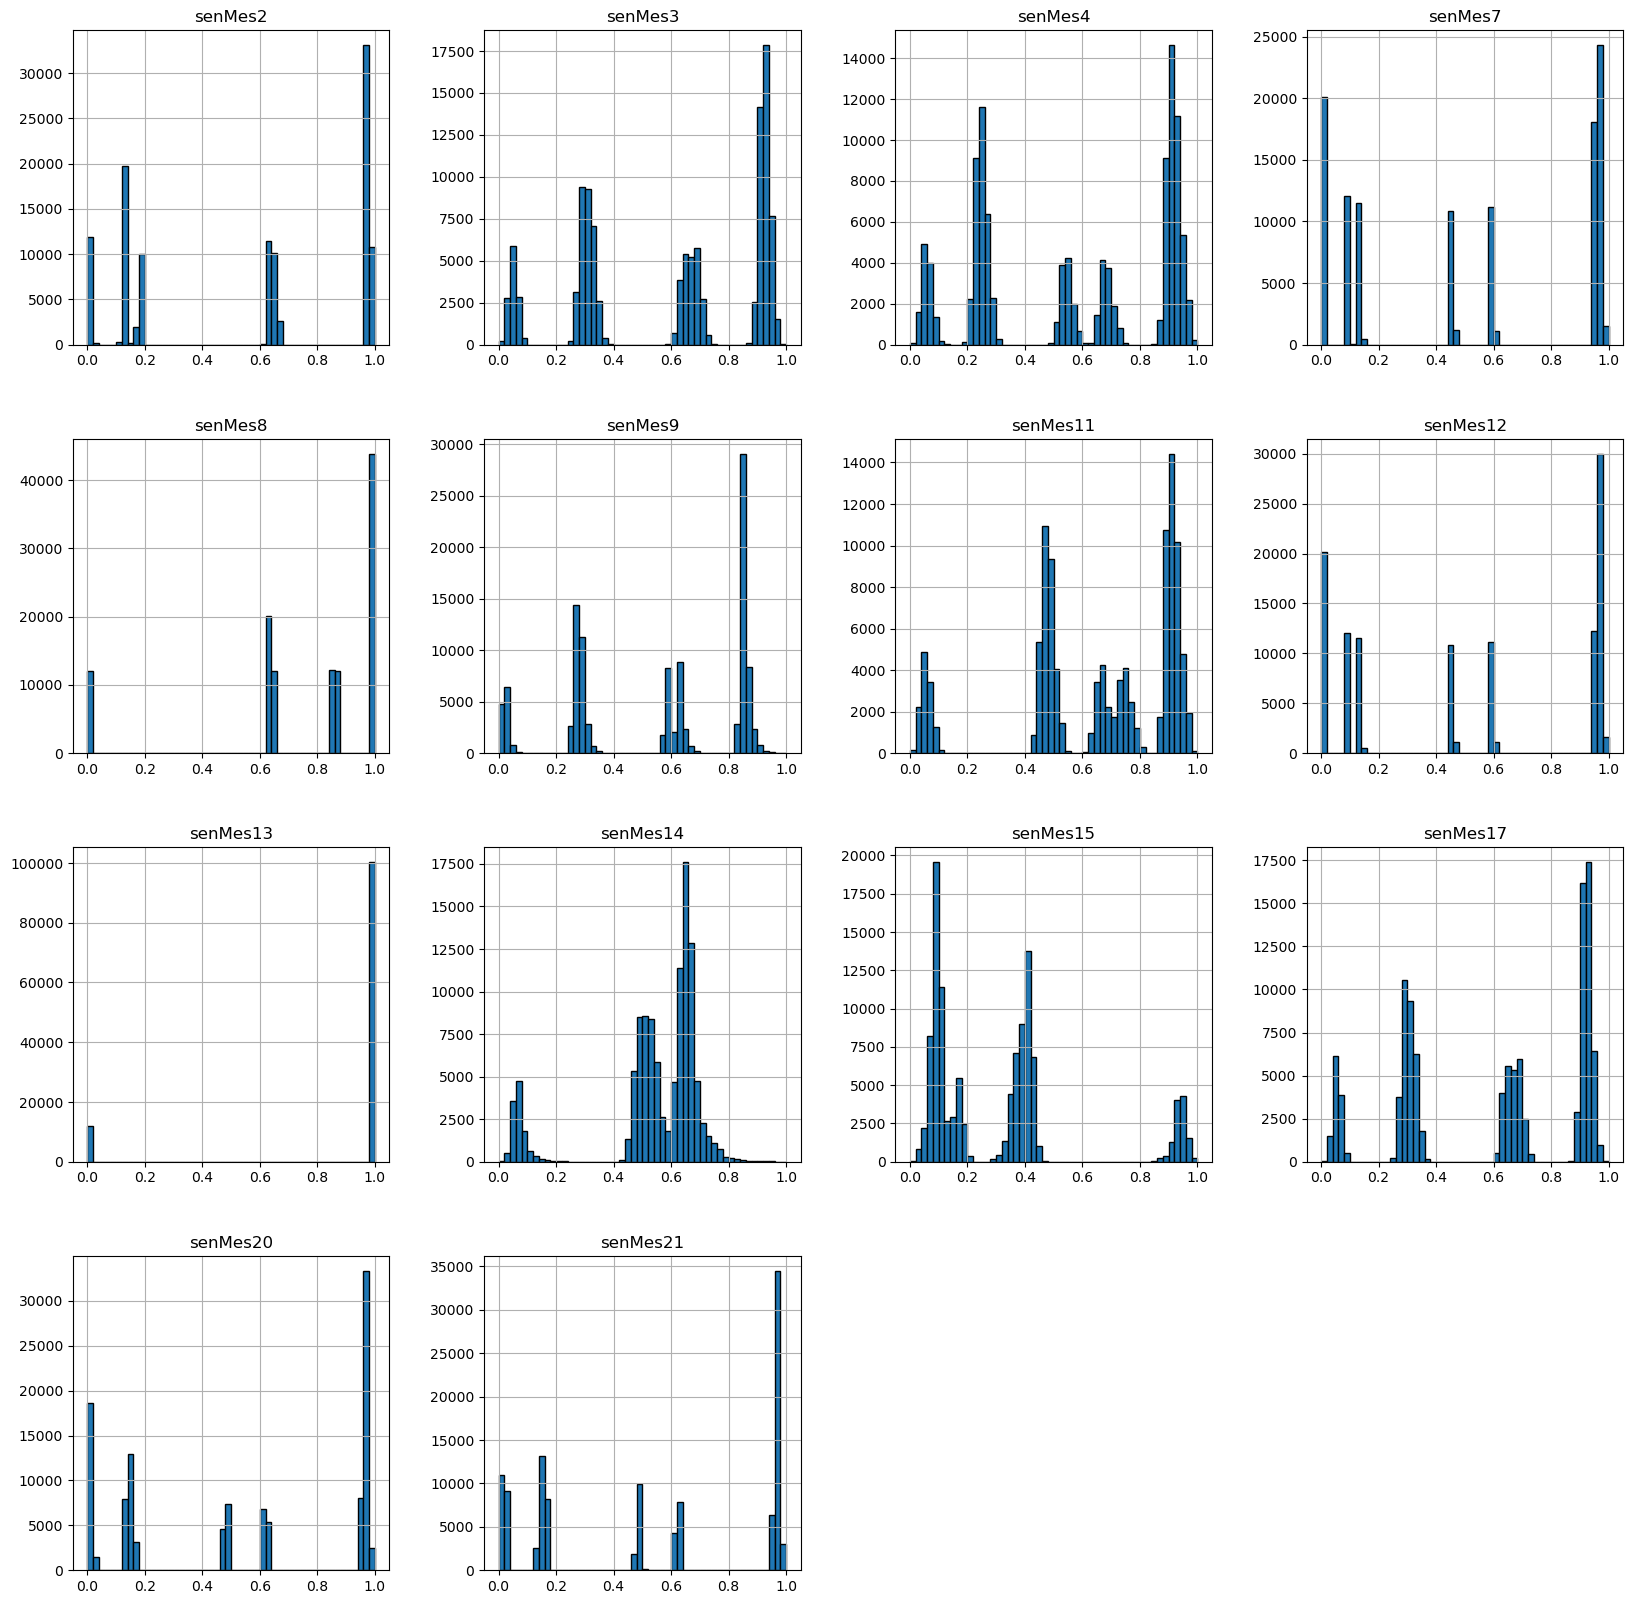

In [33]:
X_train.hist(figsize=(20, 20), bins=50, edgecolor='black')

<h1> Entrenamiento utilizando Random Forest </h1>

*  Busqueda eschaustiva de hiperparametros para entrenar posteriormente un modelo de random forest

In [52]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import RandomForestRegressor

estimator = RandomForestRegressor()
param_grid = {
    'n_estimators': [50,90,120],
    'max_depth' : [8,9,10],
}

grid = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=3)

grid.fit(X_train, y_train)

print(grid.best_score_ , grid.best_params_)

0.4017517743090731 {'max_depth': 10, 'n_estimators': 120}


* Utilizando los parametros encontrados, hacemos el randomForest

* Declaramos una función de evaluación

In [60]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))


In [64]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rf=RandomForestRegressor(n_estimators=120,  max_depth=10, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

y_hat_train = rf.predict(X_train)
evaluate(y_train,y_hat_train, label='train')
y_hat_test = rf.predict(X_test)
evaluate(y_test, y_hat_test, label='test')


train set RMSE:71.31014821764435, R2:0.4470587669899656
test set RMSE:77.06444195910626, R2:0.35250794196097623


* Visualización de los features más relevantes para el calculo de RUL

<BarContainer object of 14 artists>

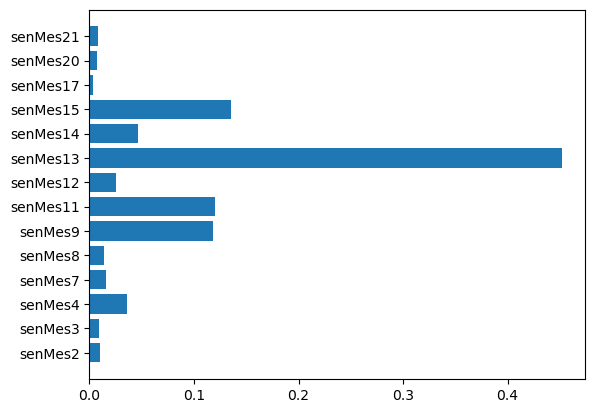

In [66]:
import pandas as pd
plt.barh(X_train.columns, rf.feature_importances_)

* Se entrenará el modelo solo con el sensor 15,14,13,12,11,9,8,7 y 4

In [76]:
selected_features_rf = ['senMes15','senMes14','senMes13','senMes12', 'senMes11', 'senMes9' ,'senMes8', 'senMes7', 'senMes4' ]
X_train_rf = X_train[selected_features_rf]
X_test_rf = X_test[selected_features_rf]


* Se entrena el modelo de nuevo con los sensores selccionados
* De nuevo se estimas los mejores parametros

In [79]:
estimator = RandomForestRegressor()
param_grid = {
    'n_estimators': [50,90,120],
    'max_depth' : [8,9,10],
}

grid = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=3)

grid.fit(X_train_rf, y_train)

print(grid.best_score_ , grid.best_params_)

0.4012430369355215 {'max_depth': 10, 'n_estimators': 120}


* De nuevo se entrena la red con random Forest y los parametros obtenidos

In [86]:
rf=RandomForestRegressor(n_estimators=120,  max_depth=10, n_jobs=-1, random_state=42)
rf.fit(X_train_rf, y_train)

y_hat_train = rf.predict(X_train_rf)
evaluate(y_train,y_hat_train, label='train')
y_hat_test = rf.predict(X_test_rf)
evaluate(y_test, y_hat_test, label='test')



train set RMSE:71.5571871896325, R2:0.443221034360454
test set RMSE:76.94642131472354, R2:0.35448963191015814


In [201]:
print(X_train_rf)

        senMes15  senMes14  senMes13  senMes12  senMes11   senMes9   senMes8  \
0       0.415120  0.466692  0.992533  0.133706  0.485188  0.283799  0.649941   
1       0.119003  0.669465  0.993607  0.959920  0.939151  0.864461  0.998966   
2       0.095533  0.674264  0.993304  0.960897  0.919936  0.859350  0.998734   
3       0.940584  0.080055  0.002039  0.088519  0.076861  0.024403  0.001519   
4       0.423918  0.500714  0.992946  0.004081  0.439552  0.257555  0.627152   
...          ...       ...       ...       ...       ...       ...       ...   
112246  0.387526  0.466089  0.993773  0.455032  0.699760  0.579281  0.863690   
112247  0.944261  0.042662  0.001240  0.087956  0.055244  0.017277  0.000717   
112248  0.391168  0.457695  0.992808  0.130432  0.436349  0.281522  0.649962   
112249  0.924433  0.039202  0.001185  0.085341  0.019215  0.009928  0.000950   
112250  0.170825  0.656941  0.993304  0.596559  0.730184  0.635087  0.852654   

         senMes7   senMes4  
0       0.

<BarContainer object of 9 artists>

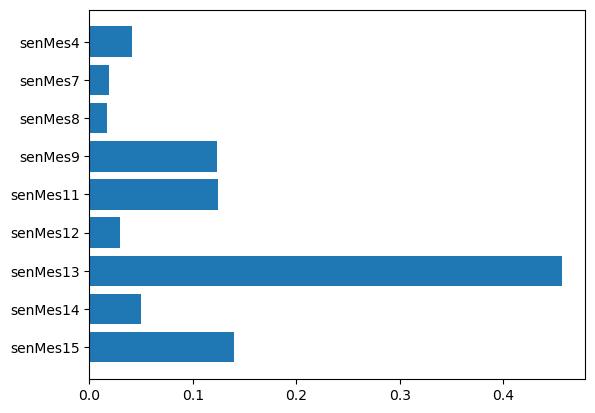

In [91]:
plt.barh(X_train_rf.columns, rf.feature_importances_)

* Se utiliza el data set de validación que es dado por el repositorio de datos de la NASA con el RUL verdadero para datos que no ha visto el algoritmo

In [224]:
selected_features = ['senMes15', 'senMes14', 'senMes13', 'senMes12', 'senMes11', 'senMes9', 'senMes8', 'senMes7', 'senMes4']

validation_rf_FD001 = df_validation_FD001_max[selected_features]

scaler = MinMaxScaler()
validation_rf_FD001  = pd.DataFrame(scaler.fit_transform(validation_rf_FD001 ), columns=validation_rf_FD001 .columns)

y_hat_valid_rf = rf.predict(validation_rf_FD001)
evaluate(y_validation_FD001, y_hat_valid_rf, label='test')

test set RMSE:79.67021310673871, R2:-2.6756352978089155


C:\Users\Verdi\AppData\Local\Temp\ipykernel_24796\1066318336.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  true_values = [int(x) for x in y_test.values]


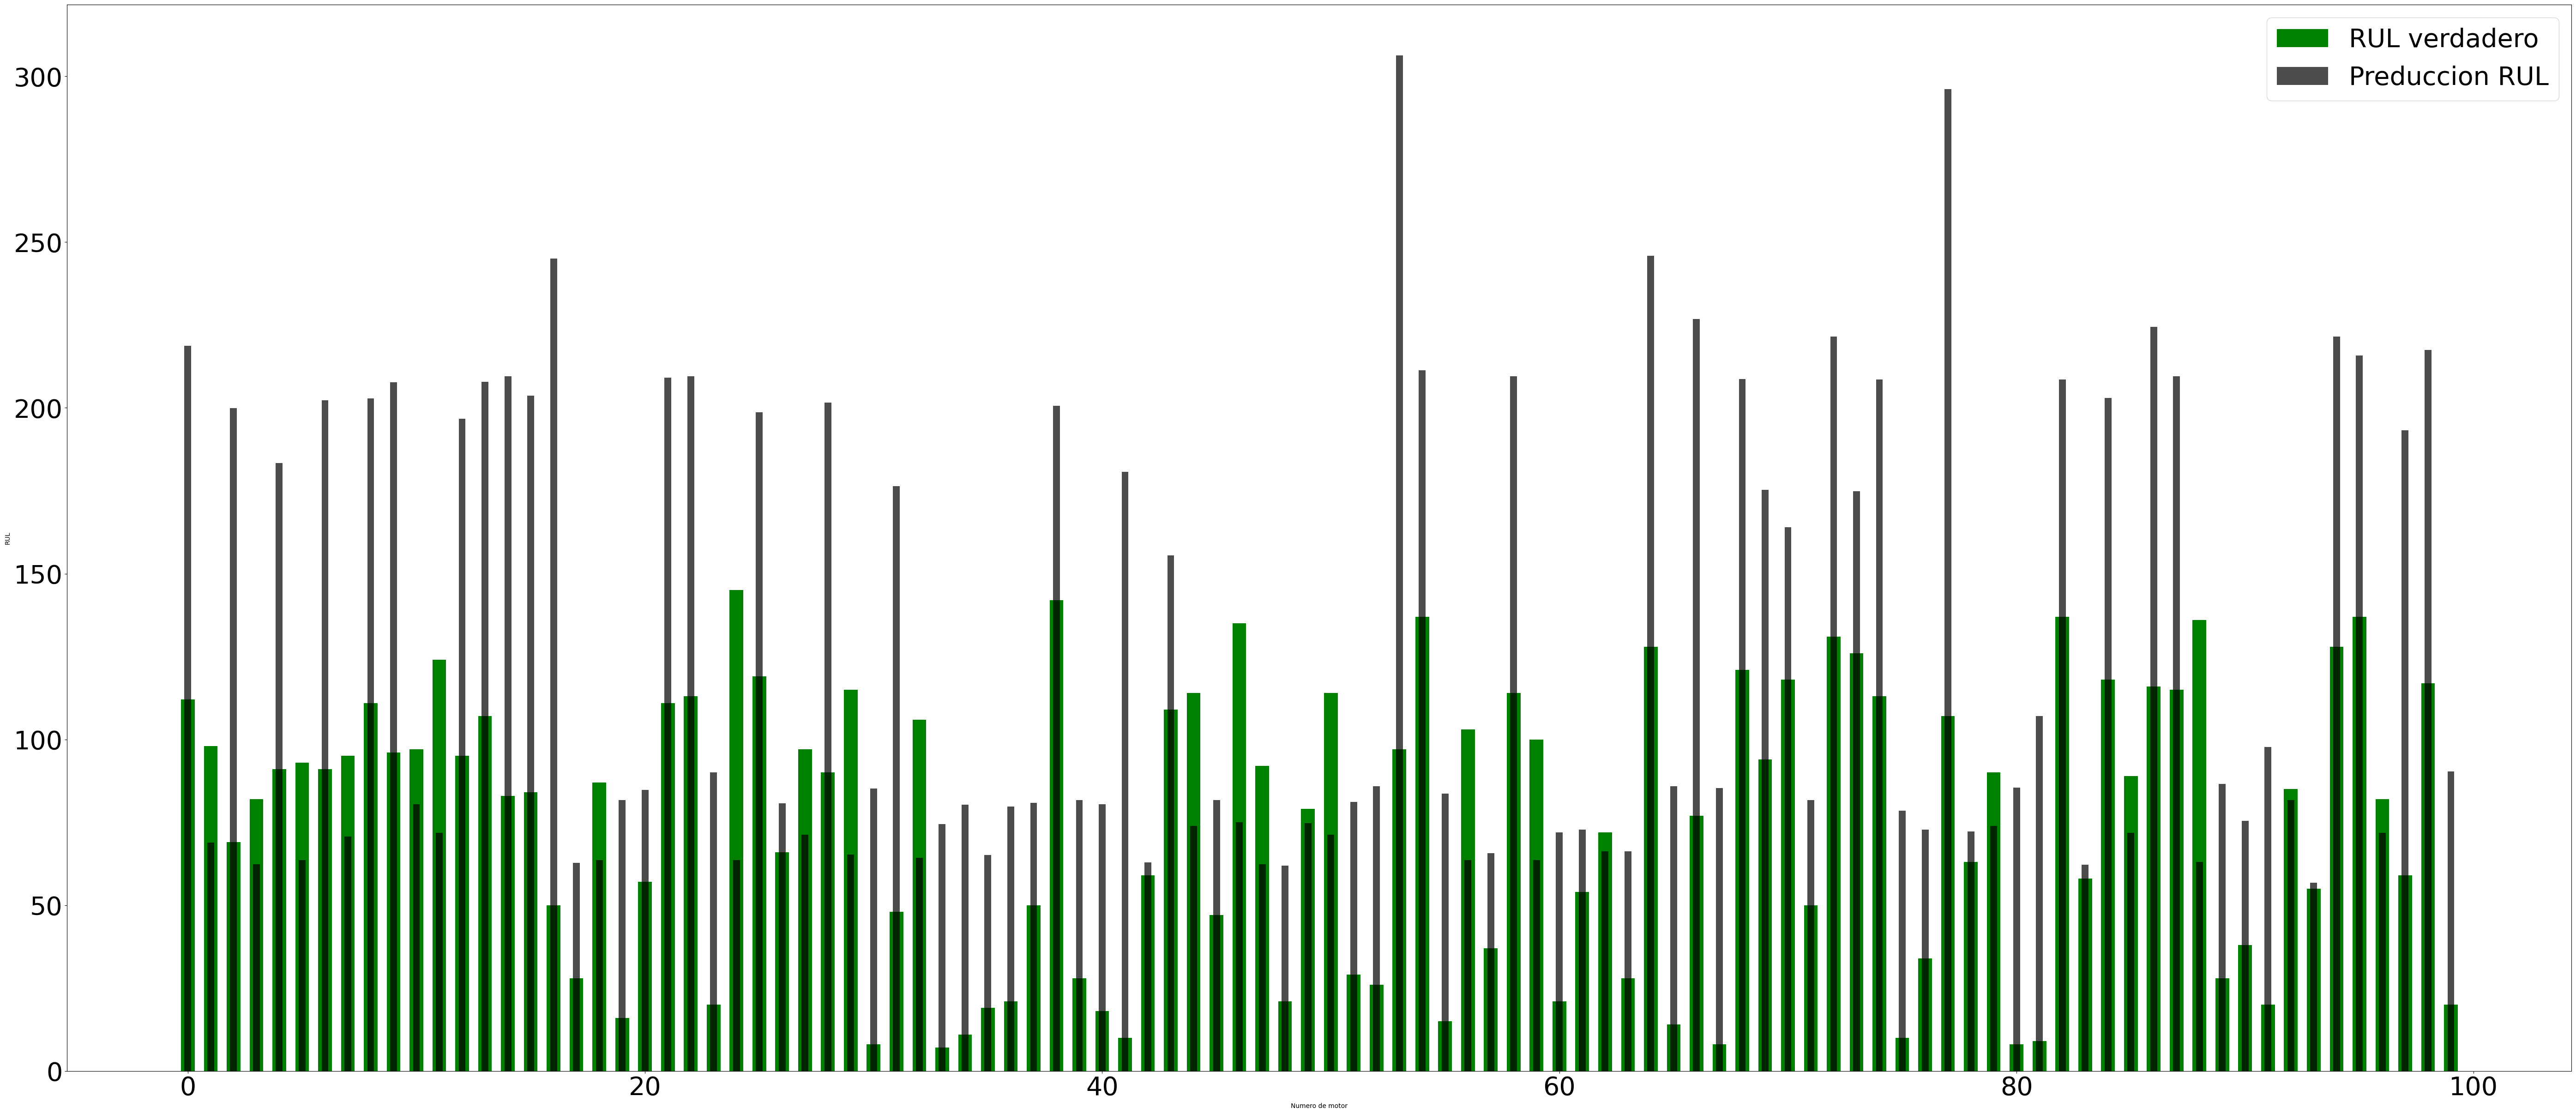

In [232]:
def plot_predActual(y_test, y_test_hat):
  
    indices = np.arange(len(y_test_hat))
    wth= 0.6
    plt.figure(figsize=(70,30))
    true_values = [int(x) for x in y_test.values]
    predicted_values = list(y_test_hat)

    plt.bar(indices, true_values, width=wth,color='g', label='RUL verdadero')
    plt.bar([i for i in indices], predicted_values, width=0.5*wth, color='k', alpha=0.7, label='Preduccion RUL')
    
    plt.legend(prop={'size': 40})
    plt.tick_params(labelsize=40)
    plt.xlabel('Numero de motor')
    plt.ylabel('RUL')
    plt.show()
    
plot_predActual(y_validation_FD001, y_hat_valid_rf)


<h1> Entrenamiento con regresión lineal </h1>

train set RMSE:82.1273103435958, R2:0.2665821116867456
test set RMSE:84.17996605169922, R2:0.2274192861668688


<BarContainer object of 14 artists>

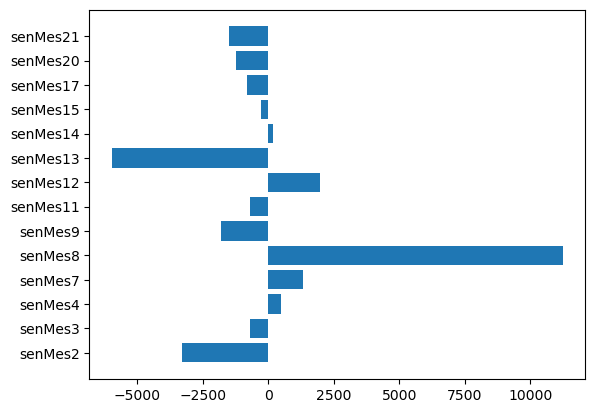

In [237]:
from sklearn.linear_model import LinearRegression


#variables para que esau use: 
#Entrenamiento:  X_train y_train, X_test, y_test (vienen ya escaladas, en 70-30)
# Validación:  
# df_validation_FD001_max: digamos es el data frame de las X, no lo modifiques copialo en alguna variable local
# validation_rf_FD001:  es el RUL es la y que debes usar, es la independiente que nos da el data set de la NADA

model = LinearRegression()
model.fit(X_train,y_train)

y_hat_train_LR = model.predict(X_train)
evaluate(y_train,y_hat_train_LR, label='train')


y_hat_test_LR = model.predict(X_test)
evaluate(y_test, y_hat_test_LR, label='test')

plt.barh(X_train.columns, model.coef_)

* Seleccion de features

In [250]:
selected_features = ['senMes2', 'senMes7', 'senMes8', 'senMes9', 'senMes12', 'senMes13', 'senMes20', 'senMes21']




X_train_LR =  X_train[selected_features]
X_test_LR =  X_test[selected_features]

y_hat_train_LR = model.predict(X_train_LR)
evaluate(y_train,y_hat_train_LR, label='train')

y_hat_test_LR = model.predict(X_test_LR)
evaluate(y_test, y_hat_test_LR, label='test')

plt.barh(X_train.columns, model.coef_)

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- senMes11
- senMes14
- senMes15
- senMes17
- senMes3
- ...


<h1> Entrenamiento con Red Neuronal usando Keras </h1>

* Entrenamiento utilizando keras 

* Plot del loss